# Copernicus Climate Change Service (C3S) - Upper Air Data Service 

    This IPython Notebook is intended for demonstration purposes and example usage of the Homogenization software for Radiosonde humidity data.
    For further information please refer to the Deliverable Document or the script `raso_adj_cdm_v0.py` on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/adjust).

 Table of Contents:
* [Downloading of data](#Downloading-of-data)
* [Investigating the data](#Investigating-the-data)
* [Running the Homogenization software](#Running-the-Homogenization-software)
* [Investigating results](#Investigating-results)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Downloading of data
For demonstration purposes, example data is allready available but we show here how to download these data from the CDS.

A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [83]:
if True:
    import requests, zipfile, io
    #
    # This is for Python 3+
    #
    # http://early-upper-air.copernicus-climate.eu
    r = requests.post('http://srvx8.img.univie.ac.at:8004',
                      headers={'content-type': 'application/json'},
                      json={"statid": "10393",
                            "date": [20000101, 20181231],
                            "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                               50000, 70000, 85000, 92500, 100000],
                            "variable": ["temperature", "relative_humidity"],
                            "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                            },
                      stream=True)
    if "Administrator" in r.text:
        print(r.text)
        raise RuntimeError("Something is not correct with the request")
    #
    # Unzip the Data Stream
    #
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Retreived files: ")
    print(z.namelist())
    z.extractall(path='./example_data')

Retreived files: 
['dest_10393_air_temperature.nc', 'dest_10393_relative_humidity.nc']


Another Way can be use a Linux tool called `curl` to download a zipfile:
```bash
curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"10393","date":[20000101,20181231],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://srvx8.img.univie.ac.at:8004
```
and then unzip the contents in the directory
```bash
unzip -o example_data/download.zip
```

In [88]:
# Show the new downloaded files in example_data directory
!tree -Dhr

.
├── [1.0K Jan 15 17:01]  README.md
├── [ 33K Jan 23 16:04]  raso_adj_cdm_v0.py
├── [245K Jan 23 16:24]  Example_Homogenization.ipynb
└── [  80 Jan 22  9:51]  example_data
    ├── [8.5M Jan 23 16:21]  dest_10393_relative_humidity.nc
    └── [8.5M Jan 23 16:21]  dest_10393_air_temperature.nc

1 directory, 5 files


In [89]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/dest_10393_air_temperature.nc

netcdf dest_10393_air_temperature {
dimensions:
	obs = 530917 ;
	string5 = 5 ;
	trajectory = 27931 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:cdmname = "observations_table/longitude" ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	float obs_minus_an(obs) ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "K" ;
		obs_minus_an:coordinates = "lat lon time plev" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_name = "air_temperature" ;
		obs_minus_an:long_name = "ERA5 reanalysis obs_minus_

# Investigating the data
This is an example, but by the end of this contract, users will be delivered similar files.

The following shows how to open these files and read information. This are very common routines for data analysis.


In [90]:
import xarray as xr

In [91]:
ident = '10393'  # Station Identifier

In [92]:
tdata = xr.load_dataset('example_data/dest_{}_air_temperature.nc'.format(ident))

In [93]:
rdata = xr.load_dataset('example_data/dest_{}_relative_humidity.nc'.format(ident))

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Observations
* trajectory_index - CDM Identifier
* trajectory_label - CDM Identifier

In [94]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 530917, trajectory: 27931)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-12-31T22:45:38
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -0.08317 -0.048345 -0.070816 ... 0.00375 0.0
    obs_minus_an      (obs) float32 0.297017 0.598117 ... 0.20772 -0.036169
    obs_minus_bg      (obs) float32 0.733175 0.495885 ... -0.338893 0.347498
    ta                (obs) float32 201.7 203.1 207.1 ... 274.61 277.48 279.37
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 27930 27930 27930 27930 27930
    trajectory_label  (trajectory) |S5 b'11865' b'11866' ... b'39817' b'39818'
Attributes:
    primary_id:    0-20000-0-10393
    sta

## Relative humidity 

In [95]:
rdata

<xarray.Dataset>
Dimensions:           (obs: 530917, trajectory: 27931)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-12-31T22:45:38
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 nan nan nan nan ... 0.952928 1.0 1.0
    obs_minus_an      (obs) float32 nan nan nan ... -0.044241 0.022678 0.000384
    obs_minus_bg      (obs) float32 nan nan nan nan ... -0.026135 0.070745 8e-06
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 27930 27930 27930 27930 27930
    trajectory_label  (trajectory) |S5 b'11865' b'11866' ... b'39817' b'39818'
Attributes:
    primary_id:    0-20000-0-10393
    st

## Plotting

Text(0.5, 1.0, 'Radiosonde Temperature Observations from 10393 at 500 hPa')

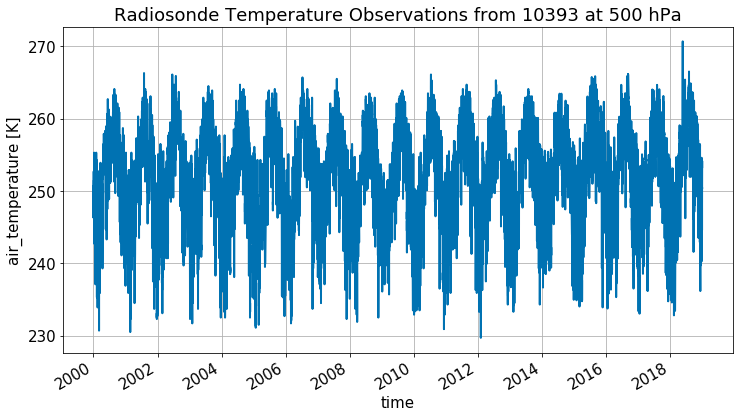

In [96]:
tdata.ta.sel(obs=(tdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde Temperature Observations from {} at 500 hPa".format(ident))

Text(0.5, 1.0, 'Radiosonde relative humidity Observations from 10393 at 500 hPa')

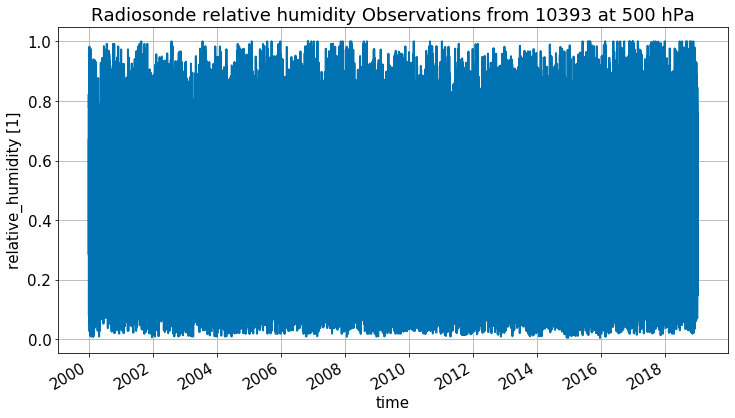

In [97]:
rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde relative humidity Observations from {} at 500 hPa".format(ident))

# Running the Homogenization Software

The following steps are completed automatically within this script:
1. Read data and convert to datacubes [time x pressure]
2. Relative humidity 
3. Calculate test statistics
4. Detect breakpoints
5. Adjust timeseries
6. Write results

The Python script can also be run from the command line:
```bash
>>> python raso_adj_cdm_v0.py -h

Run standardized radiosonde homogenisation software on CDM compliant file

raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []      Threshold value for SNHT, default: 50

```

It is also possible to import the script like a module and execute some functions individually or the `main`.

In [26]:
import raso_adj_cdm_v0

In [32]:
import importlib as imp

In [106]:
imp.reload(raso_adj_cdm_v0)

<module 'raso_adj_cdm_v0' from '/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py'>

In [107]:
data = raso_adj_cdm_v0.main('-f', "example_data/*.nc", '--verbose')

[INFO] Multiple input files:  example_data/*.nc  | # 2
[INPUT] example_data/dest_10393_air_temperature.nc ta
[INPUT] example_data/dest_10393_relative_humidity.nc hur
[OUTPUT] example_data/dest_10393_relative_humidity_out.nc
[CONVERT] Converting to DataCube ...
[CONVERT] Done
[CHECK] Departures found ta obs_minus_an
[CHECK] Departures found ta bias_estimate
[CHECK] Departures found hur obs_minus_an
[CHECK] Departures found hur bias_estimate
[SNHT] Test statistics calculted ta_obs_minus_an_snht
Breaks: [2573 6545]
[DETECT] Test statistics calculated ta_obs_minus_an_snht_breaks
Breakpoints for  ta_obs_minus_an_snht_breaks
[     idx] [     end] [    peak] [   start] [ #]
[    2573] 2001-07-22 2001-10-08 2001-12-28  633
[    6545] 2004-05-22 2004-06-30 2004-08-08  310
[SNHT] Test statistics calculted hur_obs_minus_an_snht
Breaks: [ 4667  9101 11219 12677 17925 19302 20846 21662 23150 25225 26029 27025]
[DETECT] Test statistics calculated hur_obs_minus_an_snht_breaks
Breakpoints for  hur_obs

/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py:569: RuntimeWarning: Mean of empty slice
  before = np.nanmean(data[isample], axis=axis)
/raid8/srvx1/mblaschek/.conda/envs/bunnies/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [131]:
data.time.groupby(data.time.to_index().to_period('D').to_series().to_xarray()).count()

<xarray.DataArray 'time' (time: 6932)>
array([4, 4, 4, ..., 4, 4, 4])
Coordinates:
  * time     (time) object 2000-01-01 2000-01-02 ... 2018-12-30 2018-12-31

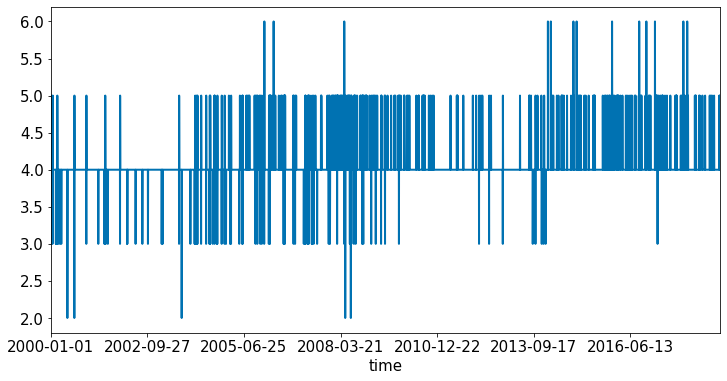

In [134]:
_131.to_series().plot()

In [135]:
def fix_datetime(itime, span=6, debug=False):
    """ Fix datetime to standard datetime with hour precision

    Args:
        itime (datetime): Datetime
        span (int): allowed difference to standard datetime (0,6,12,18)

    Returns:
        datetime : standard datetime
    """
    import pandas as pd
    itime = pd.Timestamp(itime)  # (time: 34%)
    # span=6 -> 0, 12
    # [18, 6[ , [6, 18[
    # span=3 -> 0, 6, 12, 18
    # [21, 3[, [3,9[, [9,15[, [15,21[
    for ihour in range(0, 24, span * 2):
        # 0 - 6 + 24 = 18
        lower = (ihour - span + 24) % 24
        # 0 + 6 + 24 = 6
        upper = (ihour + span + 24) % 24
        # 18 >= 18 or 18 < 6  > 00
        # 0 >= 18 or 0 < 6    > 00
        if debug:
            print("%d [%d] %d >= %d < %d" % (ihour, span, lower, itime.hour, upper))

        if (ihour - span) < 0:
            if itime.hour >= lower or itime.hour < upper:
                rx = itime.replace(hour=ihour, minute=0, second=0, microsecond=0)
                if itime.hour >= (24 - span):
                    rx = rx + pd.DateOffset(days=1)
                return rx.to_datetime64()
        else:
            if lower <= itime.hour < upper:
                rx = itime.replace(hour=ihour, minute=0, second=0, microsecond=0)
                if itime.hour >= (24 - span):
                    rx = rx + pd.DateOffset(days=1)
                return rx.to_datetime64()


In [136]:
_fix_datetime = np.vectorize(fix_datetime)

In [141]:
dates = data.time.to_index()

In [142]:
newdates = _fix_datetime(dates, span=3)

In [144]:
newdates, dates

(array(['2000-01-01T06:00:00.000000000', '2000-01-01T12:00:00.000000000',
        '2000-01-01T18:00:00.000000000', ...,
        '2018-12-31T12:00:00.000000000', '2018-12-31T18:00:00.000000000',
        '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]'),
 DatetimeIndex(['2000-01-01 05:00:00', '2000-01-01 11:00:00',
                '2000-01-01 17:00:00', '2000-01-01 23:00:00',
                '2000-01-02 06:00:00', '2000-01-02 11:00:00',
                '2000-01-02 17:00:00', '2000-01-02 23:00:00',
                '2000-01-03 05:00:00', '2000-01-03 11:00:00',
                ...
                '2018-12-29 16:46:55', '2018-12-29 22:47:21',
                '2018-12-30 04:45:12', '2018-12-30 10:45:19',
                '2018-12-30 16:48:42', '2018-12-30 23:34:38',
                '2018-12-31 04:51:57', '2018-12-31 10:46:58',
                '2018-12-31 16:48:30', '2018-12-31 22:45:38'],
               dtype='datetime64[ns]', name='time', length=27931, freq=None))

In [139]:
u, c = np.unique(newdates, return_counts=True)

In [146]:
conflicts = u[c>1]

In [147]:
np.where(newdates == conflicts[0])

(array([6753, 6754]),)

In [149]:
conflicts.size

251

In [148]:
newdates[(array([6753, 6754]),)], dates[(array([6753, 6754]),)]

(array(['2004-08-22T06:00:00.000000000', '2004-08-22T06:00:00.000000000'],
       dtype='datetime64[ns]'),
 DatetimeIndex(['2004-08-22 05:00:00', '2004-08-22 06:00:00'], dtype='datetime64[ns]', name='time', freq=None))

# Investigating results

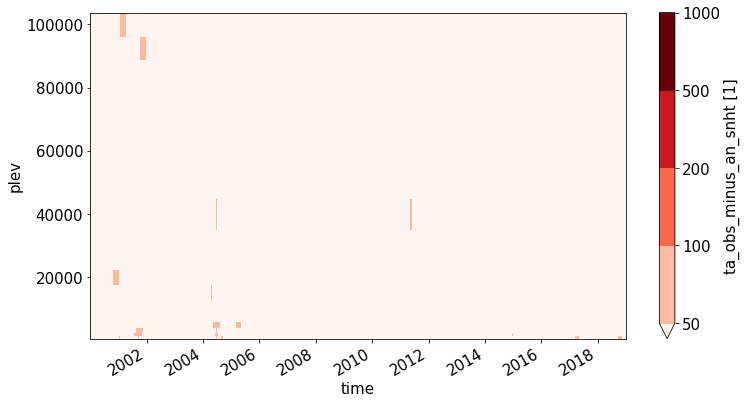

In [113]:
data.ta_obs_minus_an_snht.T.plot(cmap='Reds', levels=[50,100,200,500,1000])

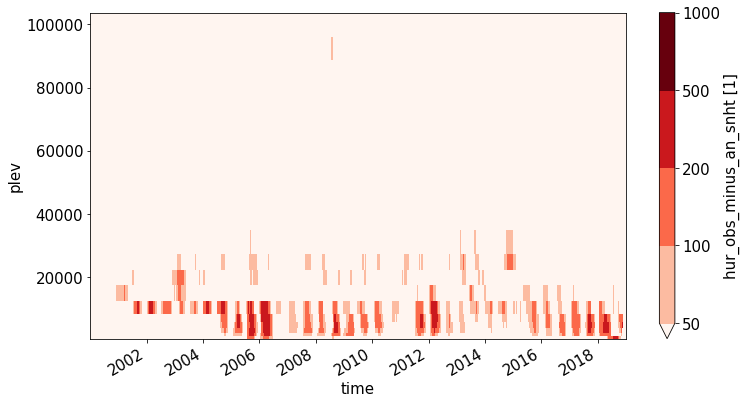

In [114]:
data.hur_obs_minus_an_snht.T.plot(cmap='Reds', levels=[50,100,200,500,1000])